In [6]:
import os
import re
import random
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import tf_memory_limit
from keras import backend as K
import theano as T
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model
from keras.layers import Input
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or pylab!e before importing pylab!
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import compress

batch_size=32
input_window=256

gen_path='/home/kal/data/ctcfgen_data.hdf5'
model_path = '/home/kal/CTCF/mass_CTCF/output/20170630_173919/20170630_173919_weights__289_0.95.hdf5'
out_dir = os.path.dirname(model_path)

In [7]:
# import seqlogo generator
import sys
sys.path.append('/home/thouis/tfmotif/H3K27ac_ANALYSIS')
import viz_sequence

In [8]:
# load the model
model = load_model(model_path, custom_objects={'Bias':Bias})

# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

# make a dictionary of key layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [19]:
# get a seq
p = gen.pos_training_gen()
n = gen.neg_training_gen()
seq = next(p)
neg_seq = next(n)

# encode sequences
encoded_seq = ctcfgen.encode(seq)
seq_batch = ctcfgen.blank_batch(encoded_seq, batch_size)
encoded_neg_seq = ctcfgen.encode(neg_seq)
neg_seq_batch = ctcfgen.blank_batch(encoded_neg_seq, batch_size)

plain_seq = seq.tostring().decode('UTF-8')
plain_neg_seq = neg_seq.tostring().decode('UTF-8')
print(plain_seq)
print(plain_neg_seq)

tttatacctagaagtgaatatgtagaagtgacatggctgggtgctgtggtaagtgtatgtataactctttaagaaactggcaaactgtttaccaaagtgactgcagttttacattcccaccagcagtacatgagagttgcggttgttctacattcttgccaacacttgataccatcaatcattttaattttaggcattctaagaagtgtggagtggcatcttactgaggccttgttttgcatttccctaatgaaca
ggttgccgcgtttggtacgaaaaaacttgtgctcctgactagggcgatagtcagactggagccttcgcctttgcaaaagtgctgaaaatcactgtatagtggctgtgtatcgtctggcaccatctcgaagccgcgcggtatttacgttatagacctacaaagtgctcaaacgattatcttgtacgttgactttagtgactccagctcttgccataacccaaaaataaattgaaaagataacaatgggttccaaact


In [20]:
# Final score difference with mutants
# get final scores
get_last_output = K.function([model.layers[0].input, K.learning_phase()], 
                                  [model.layers[-1].output])
true_pred = get_last_output([seq_batch, 0])[0][0][0]
true_neg_pred = get_last_output([neg_seq_batch, 0])[0][0][0]

print('Predicted positive: ' + str(true_pred))
print('Predicted negative: ' + str(true_neg_pred))

Predicted positive: 0.979547
Predicted negative: 0.0191741


In [21]:
# get perbase activations for mutants
m = ctcfgen.sequential_mutant_gen(seq)
mutant_preds = []
for mutant_seq in m:
    mutant_batch = ctcfgen.blank_batch(ctcfgen.encode(mutant_seq), batch_size)
    mutant_preds.append(get_last_output([mutant_batch, 0])[0][0])
diffs = [(true_pred-pred) for pred in mutant_preds]

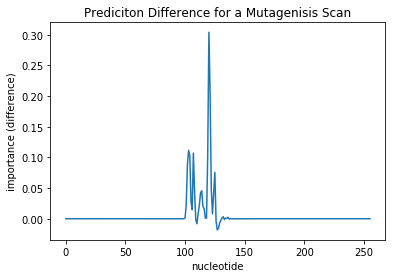

In [22]:
# plot the differences
plt.plot(diffs)
plt.title('Prediciton Difference for a Mutagenisis Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide')
plt.show()
plt.savefig(os.path.join(out_dir, 'prediction_diff.png'), bbox_inches='tight')
actual_seq = seq.tostring().decode('UTF-8')

In [23]:
# now activation difference for maximum neuron in per_seq_neurons
# start by getting activations
get_per_base_output = K.function([model.layers[0].input, K.learning_phase()], 
                                  [layer_dict['final_conv'].output])
activations = get_per_base_output([seq_batch, 0])[0]
true_factivations = activations[0] 
true_ractivations = np.flip(activations[32], axis=0)

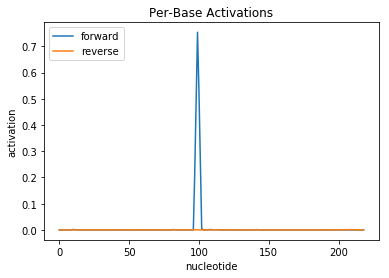

In [24]:
# plot activations
plt.plot(true_factivations)
plt.plot(true_ractivations)
plt.title('Per-Base Activations')
plt.ylabel('activation')
plt.xlabel('nucleotide')
plt.legend(['forward', 'reverse'], loc='upper left')
plt.show()
plt.savefig(os.path.join(out_dir, 'per_base_activation.png'), bbox_inches='tight')
actual_seq = seq.tostring().decode('UTF-8')

In [25]:
# get perbase activations for mutants
m = ctcfgen.sequential_mutant_gen(seq)
mutant_factivations = []
mutant_ractivations = []
for mutant_seq in m:
    mutant_batch = ctcfgen.blank_batch(ctcfgen.encode(mutant_seq), batch_size)
    mutant_factivations.append(get_per_base_output([mutant_batch, 0])[0][0])
    mutant_ractivations.append(get_per_base_output([mutant_batch, 0])[0][32]) 
    
mutant_ractivations = np.flip(mutant_ractivations, axis=1)

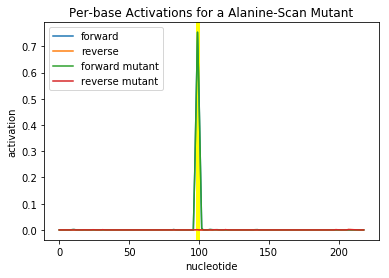

In [28]:
# plot activations of a random mutant in a series to make a gif
fig = plt.figure()
#mutant_num = random.randint(0, input_window-1)
mutant_num = 99

factivations = mutant_factivations[mutant_num]
ractivations = mutant_ractivations[mutant_num]
plt.plot(true_factivations)
plt.plot(true_ractivations)
plt.plot(factivations)
plt.plot(ractivations)
plt.title('Per-base Activations for a Alanine-Scan Mutant')
plt.ylabel('activation')
plt.xlabel('nucleotide')
plt.axvspan(mutant_num-1, mutant_num+1, color='yellow')
plt.legend(['forward', 'reverse', 'forward mutant', 'reverse mutant'], loc='upper left')
    
#ani = animation.FuncAnimation(fig , _mutant_scan_plot, range(input_window-1), interval=100,repeat=True)
plt.show()
plt.savefig(os.path.join(out_dir, 'per_base_activation_mut.png'), bbox_inches='tight')

In [29]:
# get activations of peaks
true_fpeak = max(true_factivations)
true_rpeak = max(true_ractivations)
mutant_fpeaks = [mutant_factivations[i][true_factivations.argmax()] for i in range(len(mutant_factivations))]
mutant_rpeaks = [mutant_ractivations[i][true_ractivations.argmax()] for i in range(len(mutant_ractivations))]

fdiffs = [true_fpeak - pred for pred in mutant_fpeaks] 
rdiffs = [true_rpeak - pred for pred in mutant_rpeaks]

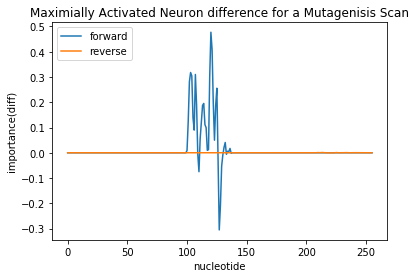

In [30]:
# plot differences
plt.plot(fdiffs)
plt.plot(rdiffs)
plt.title('Maximially Activated Neuron difference for a Mutagenisis Scan')
plt.ylabel('importance(diff)')
plt.xlabel('nucleotide')
plt.legend(['forward', 'reverse'], loc='upper left')
plt.show()
plt.savefig(os.path.join(out_dir, 'peak_neuron_diff.png'), bbox_inches='tight')

In [31]:
# get gradients with respect to final prediciton
get_gradients = K.function([model.layers[0].input, K.learning_phase()], 
                           K.gradients(model.layers[-1].output, [model.layers[0].input]))
grads = get_gradients([seq_batch, 0])[0][0]

# mask grads with input
seq_informed_grads = [list(compress(grads[idx], seq_batch[0][idx]))[0] for idx in range(len(grads))]

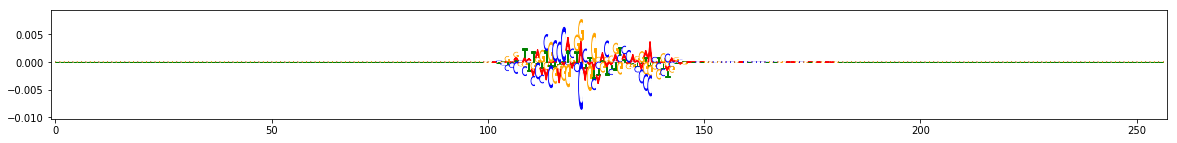

In [58]:
# make a logo of the grads
viz_sequence.plot_weights(grads)
plt.show()

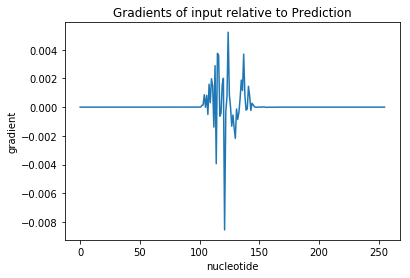

In [59]:
# plot gradients
plt.plot(seq_informed_grads)
plt.title('Gradients of input relative to Prediction')
plt.ylabel('gradient')
plt.xlabel('nucleotide')
plt.show()
plt.savefig(os.path.join(out_dir, 'prediction_gradients.png'), bbox_inches='tight')
actual_seq = seq.tostring().decode('UTF-8')

In [60]:
# look at gradient of maximally activated neuron relative to input
max_farg = true_factivations.argmax()
max_rarg = np.flip(true_ractivations, axis=0).argmax()

idx = K.placeholder(dtype='int32', shape=(2))
get_gradients = K.function([model.layers[0].input, idx, K.learning_phase()], 
                           K.gradients(model.layers[-4].output[idx[0]][idx[1]], [model.layers[0].input]))
peak_fgrads = get_gradients([seq_batch, [0, max_farg], 0])[0][0]
peak_rgrads = get_gradients([seq_batch, [32, max_rarg], 0])[0][0]

# mask grads with input
seq_informed_fgrads = [list(compress(peak_fgrads[idx], seq_batch[0][idx]))[0] for idx in range(len(peak_fgrads))]
seq_informed_rgrads = [list(compress(peak_rgrads[idx], seq_batch[0][idx]))[0] for idx in range(len(peak_rgrads))]

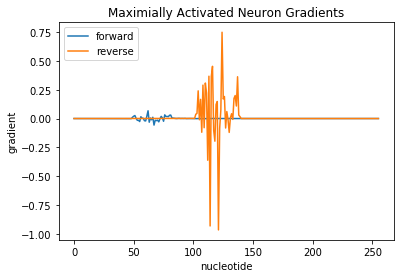

In [61]:
# plot the gradients
plt.plot(seq_informed_fgrads)
plt.plot(seq_informed_rgrads)
plt.title('Maximially Activated Neuron Gradients')
plt.ylabel('gradient')
plt.xlabel('nucleotide')
plt.legend(['forward', 'reverse'], loc='upper left')
plt.show()
plt.savefig(os.path.join(out_dir, 'peak_neuron_gradients.png'), bbox_inches='tight')

In [62]:
# compare the motifs that the methods found.
center_pred = diffs.index(max(diffs)) # from simple mutant scan
if max(rdiffs) > max(fdiffs):
    center_max = rdiffs.index(max(rdiffs))
else:
    center_max = fdiffs.index(max(fdiffs))
    
if max(seq_informed_fgrads) > max(seq_informed_rgrads):
    grad_max = seq_informed_fgrads.index(max(seq_informed_fgrads))
else:
    grad_max = seq_informed_rgrads.index(max(seq_informed_rgrads))
    
true_factivations = list(true_factivations) 
true_ractivations = list(true_ractivations)
    
if max(true_factivations) > max(true_ractivations):
    act_max = true_factivations.index(max(true_factivations))
else:
    act_max = true_ractivations.index(max(true_ractivations))
    
seq_pred = seq[center_pred-15:center_pred+15]
seq_max = seq[center_max-15:center_max+15]
seq_grad = seq[grad_max-15:grad_max+15]
seq_act = seq[act_max-15:act_max+15]



print('Prediction for mutagenisis ' + str(center_pred))
print(seq_pred.tostring().decode('UTF-8'))
print('Prediction from maximally activated nueron mutagenisis ' + str(center_max))
print(seq_max.tostring().decode('UTF-8'))
print('Prediction from gradients '  + str(grad_max))
print(seq_grad.tostring().decode('UTF-8'))
print('Prediction from activations '  + str(act_max)) # doesn't seem to work
print(seq_act.tostring().decode('UTF-8'))

Prediction for mutagenisis 125
tacccccacctcgtggctatgggtggaaca
Prediction from maximally activated nueron mutagenisis 116
cctggggtctacccccacctcgtggctatg
Prediction from gradients 124
ctacccccacctcgtggctatgggtggaac
Prediction from activations 122
gtctacccccacctcgtggctatgggtgga


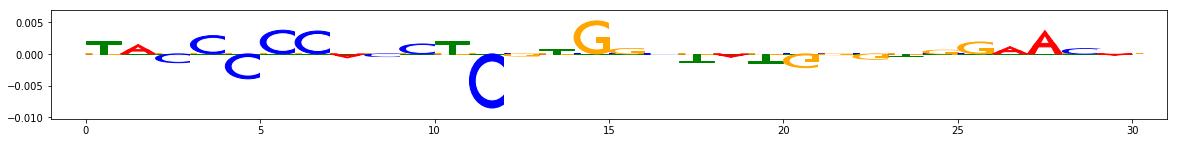

In [63]:
weighted = np.asarray(ctcfgen.encode(seq) * grads)
viz_sequence.plot_weights(weighted[center_pred-15:center_pred+15])

In [64]:
def plot_activations(model, input_seqs, layer_name, all=True, viz=False, get_max=False, pre_max=None):
    seqs = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    get_activations = K.function([seqs, K.learning_phase()], [layer_dict[layer_name].output, model.output])
    cmap = plt.get_cmap('plasma')
    def plot(ax, data, max_act):
        im = ax.imshow(data, interpolation='nearest',
                    cmap = cmap,
                    origin='lower',
                    aspect='auto', vmin=0, vmax = max_act)
        fig.colorbar(im, ax=ax)
        
    activations, predictions = get_activations([input_seqs, 0])
    print(activations.shape)
    
    if all:                
        for fact, ract, seq, pred in zip(activations[:32], activations[32:], input_seqs, predictions):
            if pre_max==None:
                max_act=max(np.amax(fact), np.amax(ract))
            else:
                max_act = pre_max
            fig, (ax1, ax2) = plt.subplots(ncols=2)
            ax1.set(title='Forward (' + str(pred[0]) + ')')
            plot(ax1, np.transpose(fact), max_act)

            ax2.set(title='Reverse ('  + str(pred[0]) +')')
            plot(ax2, np.transpose(np.flip(ract, axis=0)), max_act)
            plt.tight_layout()
            plt.show()
            if viz:
                viz_sequence.plot_icweights(seq)
            if get_max:
                return max_act
    else:
        if pre_max==None:
            max_act=max(np.amax(activations[0]), np.amax(activations[32]))
        else:
            max_act=pre_max
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        ax1.set(title='Forward (' + str(predictions[0][0]) + ') ' + layer_name)
        plot(ax1, np.transpose(activations[0]), max_act)

        ax2.set(title='Reverse ('  + str(predictions[0][0]) +') '+ layer_name)
        plot(ax2, np.transpose(np.flip(activations[32], axis=0)), max_act)
        plt.tight_layout()
        plt.show()  
        if viz:
            viz_sequence.plot_icweights(input_seqs[0])
        if get_max:
                return max_act


(64, 256, 8)


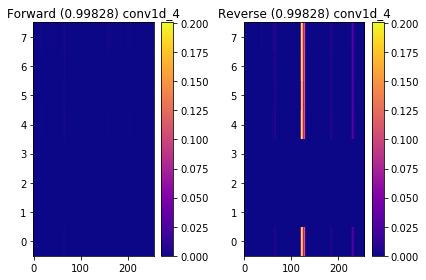

In [65]:
plot_activations(model, ctcfgen.blank_batch(ctcfgen.encode(seq), batch_size=32), 'conv1d_4', all=False)